In [1]:
!pip install openrouteservice folium

In [1]:
import openrouteservice
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"
client = openrouteservice.Client(key=API_KEY)

def get_coordinates(place_name):
    # Function to get coordinates from place name
    result = client.pelias_search(place_name)
    
    if result and "features" in result and len(result["features"]) > 0:
        coords = result["features"][0]["geometry"]["coordinates"]
        return coords[1], coords[0]  # (Latitude, Longitude)
    else:
        return None

# Example Usage
place = "Graphic Era Hill University,Dehradun"
lat, lon = get_coordinates(place)
print(f"Coordinates of {place}: {lat}, {lon}")

Coordinates of Graphic Era Hill University,Dehradun: 30.273002, 78.000246


In [5]:
import folium

def get_distance_time_and_plot(place1: str, place2: str):
    # 2) Geocode both ends
    coords1 = get_coordinates(place1)
    coords2 = get_coordinates(place2)
    if not coords1 or not coords2:
        raise ValueError("One or both locations could not be geocoded.")

    # 3) ORS wants [(lon, lat), (lon, lat)]
    ors_coords = [(coords1[1], coords1[0]), (coords2[1], coords2[0])]

    # 4) Request up to 3 alternative driving routes
    routes = client.directions(
        coordinates=ors_coords,
        profile='driving-car',
        format='geojson',
        optimize_waypoints=True,
        alternative_routes={
            "share_factor": 0.6,   # how different alternatives must be
            "target_count": 3    # number of total routes requested
        }
    )

    # 5) Take the first feature for the “primary” distance/time summary
    primary = routes['features'][0]['properties']['segments'][0]
    distance_km = primary['distance'] / 1000       # km
    duration_min = primary['duration'] / 60        # minutes

    # 6) Create folium map centered on the start
    m = folium.Map(location=coords1, zoom_start=12)
    folium.Marker(coords1, popup=f"Start: {place1}", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker(coords2, popup=f"End: {place2}", icon=folium.Icon(color="red")).add_to(m)

    # 7) Plot each alternative route in a different color
    colors = ['blue', 'green', 'red']
    for idx, feat in enumerate(routes['features']):
        geom = feat['geometry']['coordinates']  # list of [lon,lat]
        # flip to [(lat, lon), ...]
        latlons = [(lat, lon) for lon, lat in geom]
        folium.PolyLine(
            latlons,
            color=colors[idx % len(colors)],
            weight=4,
            opacity=0.7,
            tooltip=(
                f"Route {idx+1}: "
                f"{feat['properties']['summary']['distance']/1000:.1f} km, "
                f"{feat['properties']['summary']['duration']/60:.0f} min"
            )
        ).add_to(m)

    # 8) Print summary and return map
    print(f"Route {idx+1}: Distance = {distance_km:.2f} km, Estimated Time = {duration_min:.1f} min")
    return m

# Example usage:
place1 = "Marina Hostel, Graphic Era Hill University, Dehradun"
place2 = "Paltan Bazar, Dehradun"
map_result = get_distance_time_and_plot(place1, place2)
map_result  # in Jupyter this will render; in scripts use map_result.save("map.html")

Route 3: Distance = 11.81 km, Estimated Time = 14.0 min


C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

Optimal number of clusters (k): 2


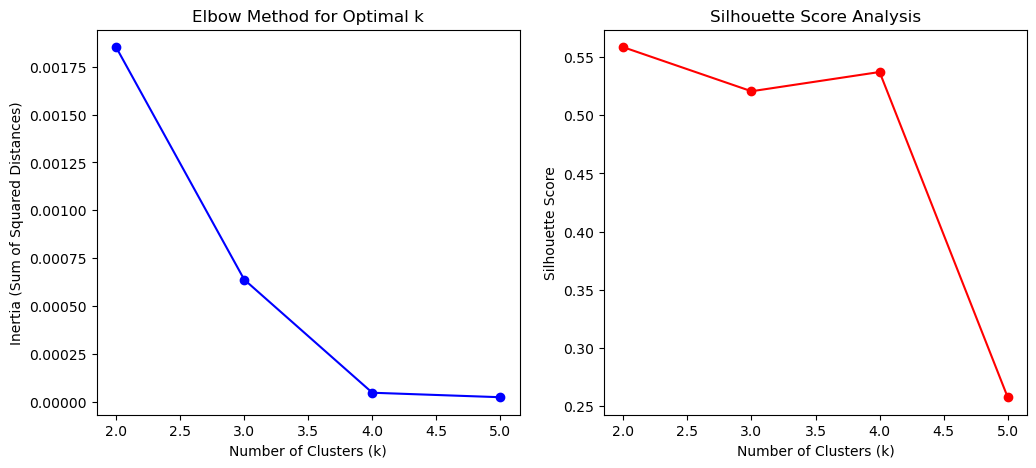

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Example delivery locations (Replace with actual locations from your dataset)
locations = [
    "Rajpur Road, Dehradun",
    "ISBT, Dehradun",
    "Paltan Bazar, Dehradun",
    "Graphic Era Deemed to be University, Dehradun",
    "Prem Nagar, Dehradun",
    "Graphic Era Hill University, Dehradun"
]

# Convert place names to coordinates
coords_array = np.array([get_coordinates(loc) for loc in locations])  # Convert locations to coordinates

# Ensure k < number of locations
K_range = range(2, min(len(coords_array), 7))  # Adjusted range

inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(coords_array)
    
    inertia.append(kmeans.inertia_)  # Inertia
    if k < len(coords_array):  # Avoid silhouette error
        silhouette_scores.append(silhouette_score(coords_array, cluster_labels))
    else:
        silhouette_scores.append(None)  # Placeholder for invalid k

# Find the best k (highest silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]  # Selecting k with the highest Silhouette Score
print(f"Optimal number of clusters (k): {optimal_k}")

# Plot Elbow Method
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Score (ignoring None values)
valid_k = [k for k, score in zip(K_range, silhouette_scores) if score is not None]
valid_scores = [score for score in silhouette_scores if score is not None]

plt.subplot(1,2,2)
plt.plot(valid_k, valid_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analysis')

plt.show()

C:\Users\asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


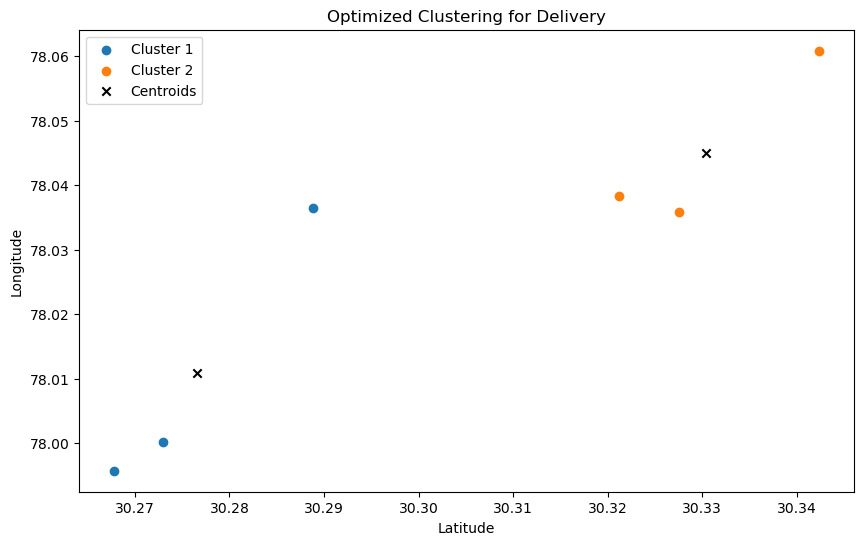

In [9]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(coords_array)

# Assign vehicles (1 vehicle per cluster)
vehicle_assignments = {i: [] for i in range(optimal_k)}
for i, label in enumerate(cluster_labels):
    vehicle_assignments[label].append(coords_array[i])  # Assign location to a vehicle

# Convert dictionary to a list for easy processing
vehicles_clusters = [np.array(vehicle_assignments[i]) for i in range(optimal_k)]

# Visualizing the clusters
plt.figure(figsize=(10, 6))
for i in range(optimal_k):
    plt.scatter(vehicles_clusters[i][:, 0], vehicles_clusters[i][:, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black', marker='x', label="Centroids")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Optimized Clustering for Delivery")
plt.legend()
plt.show()

In [11]:
# Initialize map centered at Dehradun
map_center = [np.mean(coords_array[:, 0]), np.mean(coords_array[:, 1])]
m = folium.Map(location=map_center, zoom_start=13)

# Define cluster colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige']

# Plot locations on the map
for i, (lat, lon) in enumerate(coords_array):
    cluster_id = cluster_labels[i]
    place_name = locations[i]  # Get the place name
    popup_text = f"{place_name} (Cluster {cluster_id + 1})"
    
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=colors[cluster_id % len(colors)])
    ).add_to(m)

# Plot cluster centroids
for i, (lat, lon) in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        location=[lat, lon],
        popup=f"Centroid {i + 1}",
        icon=folium.Icon(color='black', icon='cloud')
    ).add_to(m)

# Display the map
m

In [ ]:
import heapq
from math import radians, cos, sin, sqrt, atan2

# Sample city coordinates (latitude, longitude)
locations = {
    'New York': (40.71427, -74.00597),
    'Hartford': (41.76371, -72.68509),
    'Boston': (42.36008, -71.05888),
    'Albany': (42.65258, -73.75623)
}

# Graph: Neighbors and distances (in km, approx)
graph = {
    'New York': {'Hartford': 190, 'Albany': 240},
    'Hartford': {'Boston': 160, 'New York': 190},
    'Boston': {'Hartford': 160},
    'Albany': {'New York': 240, 'Boston': 270}
}

# Haversine distance (heuristic)
def haversine(coord1, coord2):
    R = 6371  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

# A* Algorithm
def astar(start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {city: float('inf') for city in graph}
    g_score[start] = 0
    f_score = {city: float('inf') for city in graph}
    f_score[start] = haversine(locations[start], locations[goal])

    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], g_score[goal]

        for neighbor, dist in graph[current].items():
            tentative_g = g_score[current] + dist
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + haversine(locations[neighbor], locations[goal])
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None, float('inf')

# Run A* from New York to Boston
path, total_distance = astar('New York', 'Boston')
print("A* Path:", path)
print("Total Distance:", total_distance, "km")


In [2]:
import openrouteservice
from openrouteservice.optimization import Vehicle, Job

# ORS API Key
API_KEY = "5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2"

# Initialize ORS client
client = openrouteservice.Client(key=API_KEY)

# Coordinates (longitude, latitude)
locations = [
    [77.2090, 28.6139],  # Delhi (Depot)
    [75.7873, 26.9124],  # Jaipur
    [78.0081, 27.1767],  # Agra
    [78.1642, 29.9457],  # Haridwar
]

# Create jobs (excluding depot at index 0)
jobs = [
    Job(id=i, location=loc)
    for i, loc in enumerate(locations[1:], start=1)
]

# Define the vehicle (starting and ending at the depot)
vehicle = Vehicle(
    id=0,
    start=locations[0],
    end=locations[0]
)

# Now call the optimization API
try:
    result = client.optimization(
        jobs=jobs,
        vehicles=[vehicle]
    )

    print("📍 Optimized TSP Route:")
    for step in result['routes'][0]['steps']:
        step_type = step.get("type")
        if step_type == "start":
            print(f"Start at depot: {locations[0]}")
        elif step_type == "job":
            job_id = step['job']
            print(f"Visit: {locations[job_id]}")
        elif step_type == "end":
            print(f"Return to depot: {locations[0]}")
except Exception as e:
    import traceback
    print("❌ Error occurred:")
    traceback.print_exc()


📍 Optimized TSP Route:
Start at depot: [77.209, 28.6139]
Visit: [75.7873, 26.9124]
Visit: [78.0081, 27.1767]
Visit: [78.1642, 29.9457]
Return to depot: [77.209, 28.6139]


In [4]:
import openrouteservice
import folium

# Replace with your actual ORS API key
ORS_API_KEY = '5b3ce3597851110001cf6248d909b0549b614bde8aac0f381c393ba2'

# Coordinates: (longitude, latitude) format
# Example: From New York to Boston via Hartford
coordinates = [
    (-74.00597, 40.71427),  # New York
    (-72.68509, 41.76371),  # Hartford
    (-71.05888, 42.36008)   # Boston
]

# Initialize ORS client
client = openrouteservice.Client(key=ORS_API_KEY)

# Request directions for car
route = client.directions(
    coordinates=coordinates,
    profile='driving-car',
    format='geojson'
)

# Extract total distance and duration
distance_m = route['features'][0]['properties']['segments'][0]['distance']
duration_s = route['features'][0]['properties']['segments'][0]['duration']

# Convert to km and minutes
distance_km = distance_m / 1000
duration_min = duration_s / 60

print(f"Total Distance (TRP): {distance_km:.2f} km")
print(f"Total Duration: {duration_min:.2f} minutes")

# Plot the route on a map
m = folium.Map(location=[41.5, -73.5], zoom_start=7)

# Add route
folium.GeoJson(route, name='route').add_to(m)

# Add markers
for coord in coordinates:
    folium.Marker(location=[coord[1], coord[0]]).add_to(m)

# Save the map to an HTML file
m.save("route_map.html")
print("Map saved as route_map.html")


Total Distance (TRP): 185.30 km
Total Duration: 174.74 minutes
Map saved as route_map.html
